In [1]:
%load_ext  autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [249]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from collections import defaultdict

import pickle
import plot_params

### Utilities

In [167]:
def load_results(datafile):
    with open(datafile, 'rb') as f:
        results = pickle.load(f)
        return results
    
def group_by_key(data, key):
    obj = defaultdict(list)
    for d in data:
        value = d[key]
        obj[value].append(d)        
    return obj

In [454]:
def get_improvement(ast_results, bfs_results):
    assert ast_results['index'].equals(bfs_results['index'])
    assert ast_results['found'].equals(bfs_results['found'])
    
    # Get the expansion arrays.
    bfs_expansions = bfs_results['nodes_expanded']
    ast_expansions = ast_results['nodes_expanded']
    
    # Obtain indexes that would sort the BFS expansions array.
    idxs = np.argsort(bfs_expansions.values)
    
    # Use indexes to sort BFS and A* expansions arrays and compute improvement. 
    bfs_expansions_sorted = bfs_expansions.values[idxs]
    ast_expansions_sorted = ast_expansions.values[idxs]
    
    improvement = (bfs_expansions_sorted / ast_expansions_sorted)
    return improvement, ast_expansions_sorted, bfs_expansions_sorted

In [467]:
def get_path_cost_increase(ast_results, bfs_results):
    assert ast_results['index'].equals(bfs_results['index'])
    assert ast_results['found'].equals(bfs_results['found'])
    
    print(bfs_results.columns)
    
    # Get the expansion arrays.
    bfs_path_cost = bfs_results['path_cost']
    ast_path_cost = ast_results['path_cost']
    
    # Obtain indexes that would sort the BFS expansions array.
    idxs = np.argsort(bfs_path_cost.values)
    
    # Use indexes to sort BFS and A* expansions arrays and compute improvement. 
    bfs_path_cost_sorted = bfs_path_cost.values[idxs]
    ast_path_cost_sorted = ast_path_cost.values[idxs]
    
    increase = (ast_path_cost_sorted / bfs_path_cost_sorted)
    return increase, ast_path_cost_sorted, bfs_path_cost_sorted

### Load data

In [324]:
# Load results from running adversarial search on credit dataset.
results = load_results('../out/credit.pickle')

### Plot results over different bins

In [606]:
WEIGHTED_EPSILONS = [2.5, 5]
BEST_FIRST_EPSILON = 10e+5

In [511]:
results_by_bin = group_by_key(results, 'bins')
attack_perf_df = pd.DataFrame(columns=['bins', 'index', 'expansions', 'improvement', 'eps'])
clf_perf_df = pd.DataFrame(columns=['bins', 'accuracy', 'robustness'])
costs_df = pd.DataFrame(columns=['bins', 'index', 'eps', 'pathcost', 'pathcostincrease'])

models = []

for bins, items in results_by_bin.items():
    
    clf_perf_df = perf_df.append({
            'bins': bins,
            'accuracy': items[0]['clf_test_score'],
        }, ignore_index=True)
    
    models.append(items[0]['classifier'])
    
    for item in items:
        ast_results, bfs_results = item['search_results'], item['baseline_results']
            
        for index, ast_expansions, bfs_expansions in zip(
                ast_results['index'], ast_results['nodes_expanded'], bfs_results['nodes_expanded']):
            attack_perf_df = attack_perf_df.append(
                {
                    'bins': bins,
                    'index': index,
                    'eps': item['epsilon'],
                    'expansions': ast_expansions,
                    'improvement': bfs_expansions / ast_expansions,
                },
                ignore_index=True
            )
            
        for index, ast_path_cost, bfs_path_cost in zip(
                ast_results['index'], ast_results['path_cost'], bfs_results['path_cost']):
            costs_df = costs_df.append(
                {
                    'bins': bins,
                    'index': index,
                    'eps': item['epsilon'],
                    'pathcost': bfs_path_cost,
                    'pathcostincrease': ast_path_cost / bfs_path_cost
                },
                ignore_index=True
            )

In [512]:
coefs = np.array([model.coef_[0] for model in models])

In [478]:
coefs_norm = []
for coef_vec in coefs:
    coef_vec_norm = np.array(coef_vec)
    coef_vec_norm += np.abs(np.min(coef_vec_norm))
    coef_vec_norm /= np.sum(np.abs(coef_vec_norm))
    coefs_norm.append(coef_vec_norm)
    
coefs_norm = np.array(coefs_norm)

In [ ]:
sharpness = np.array([np.ediff1d(coef).mean() for coef in coefs_norm])

In [480]:
FIGWIDTH = 8.5
FIGHEIGHT = 6.5

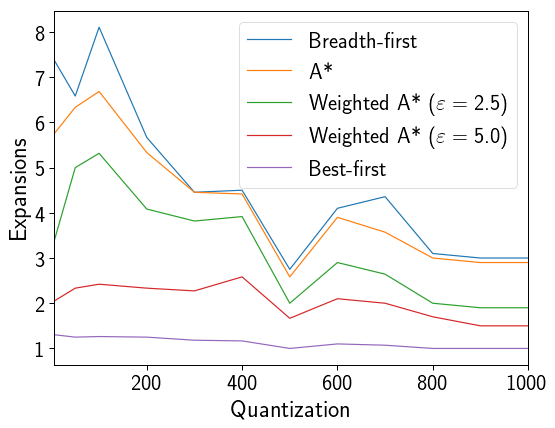

In [607]:
fig, ax = plt.subplots()

sns.lineplot(data=attack_perf_df.query('eps == 0'),
             x='bins', y='expansions', ax=ax, label='Breadth-first',
             ci=None)

sns.lineplot(data=attack_perf_df.query('eps == 1'),
             x='bins', y='expansions', ax=ax, label='A*',
             ci=None)

for eps in WEIGHTED_EPSILONS:
    sns.lineplot(data=attack_perf_df.query('{0} - 0.1 < eps < {0} + 0.1'.format(eps)),
                 x='bins', y='expansions', ax=ax,
                 label='Weighted A* ($\\varepsilon = %1.1f$)' % eps,
                 ci=None)


sns.lineplot(data=attack_perf_df.query('eps == %d' % BEST_FIRST_EPSILON),
             x='bins', y='expansions', ax=ax, label='Best-first',
             ci=None)


ax.set_ylabel('Expansions')
ax.set_xlim(5, 1000)
ax.set_xlabel('Quantization')
ax.legend()  # bbox_to_anchor=(1.6, .68)

#     ax2 = ax.twinx()
#     ax2.plot(clf_perf_df.bins, sharpness,
#              label='Gradient sharpness',
#              linestyle='--', color='grey', marker='D')
#     ax2.legend(loc=5)

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

fig.savefig('../out/credit_different_bins_perf.pdf')

### Plot results for one bin

In [485]:
# Group the results by the required key.
results_by_key = group_by_key(results, 'epsilon')

# Pick the number of bins to examine (this can be computed in different ways).
bins = 100

improvements = {}
ast_sorts = {}
for epsilon, items in results_by_key.items():
    
    for item in items:
        
        if item['bins'] != bins:
            continue
        
        ast_results, bfs_results = item['search_results'], item['baseline_results']
        improvement = get_improvement(ast_results, bfs_results)
        
        improvements[epsilon] = improvement[0]
        ast_sorts[epsilon] = improvement[1]
        
bfs_sort = improvement[2] # changing epslion does not change bfs results

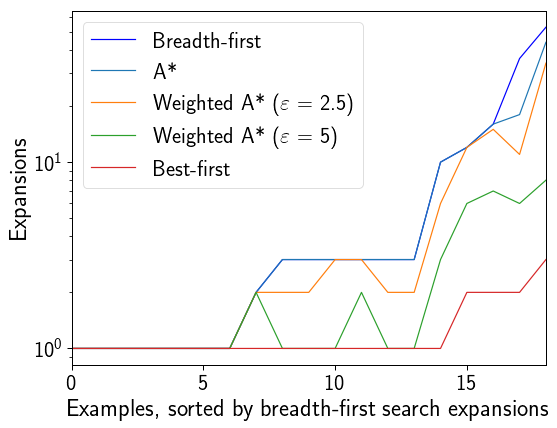

In [609]:
fig, ax = plt.subplots()

ax.plot(bfs_sort, color='blue', label='Breadth-first')
ax.plot(ast_sorts[1], label='A*')

for eps in WEIGHTED_EPSILONS:
    ast_sort = ast_sorts[eps]
    ax.plot(ast_sort, label='Weighted A* ($\\varepsilon$ = {})'.format(eps))
    
ax.plot(ast_sorts[BEST_FIRST_EPSILON], label='Best-first')

ax.set_xlabel('Examples, sorted by breadth-first search expansions')
ax.set_ylabel('Expansions')
ax.set_yscale('log')
ax.set_xlim(0, len(bfs_sort) - 1)
ax.legend(loc='best')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

plt.show()

fig.savefig('../out/credit_performance_bin_%d.pdf' % bins)

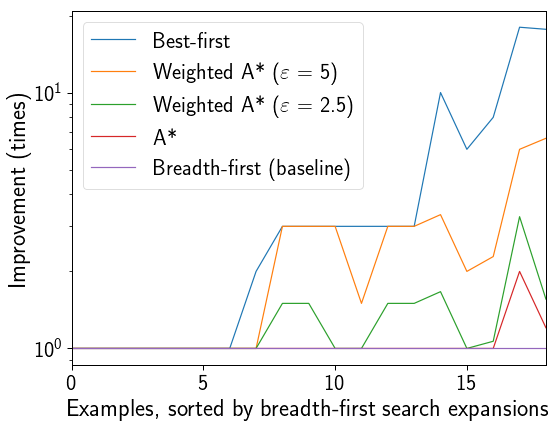

In [611]:
fig, ax = plt.subplots()

ax.plot(improvements[10e+5], label='Best-first')

for eps in reversed(WEIGHTED_EPSILONS):
    improv = improvements[eps]
    ax.plot(improv, label='Weighted A* ($\\varepsilon$ = {})'.format(eps))

ax.plot(improvements[1], label='A*')
ax.plot(improvements[0], label='Breadth-first (baseline)')
    
ax.set_xlabel('Examples, sorted by breadth-first search expansions')
ax.set_ylabel('Improvement (times)')
ax.set_yticks([1, 2.5, 5, 7.5, 10, 12.5, 15, 17.5])
ax.set_xlim(0, len(improvements[0]) - 1)
ax.set_yscale('log')
ax.legend(loc='best')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

fig.savefig('../out/credit_improvement_bin_%d.pdf' % bins)

In [603]:
pseudo_costs_df = costs_df.copy()
pseudo_costs_df.eps = pseudo_costs_df.eps.apply(func=lambda val: 6 if val == 10e+5 else val)
# pseudo_costs_df.pathcost = pseudo_costs_df.pathcost / 2

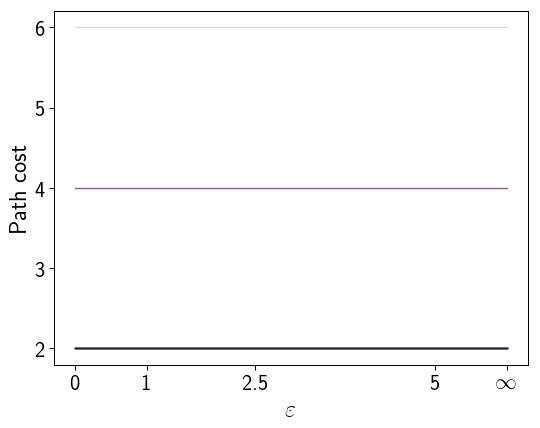

In [605]:
fig, ax = plt.subplots()

sns.lineplot(data=pseudo_costs_df.query('bins==1000'),
             x='eps', y='pathcost', hue='index',
             estimator=None, ci=None, ax=ax, legend=False)
sns.lineplot(data=pseudo_costs_df.query('bins==100'),
             x='eps', y='pathcost', hue='index',
             estimator=None, ci=None, ax=ax, legend=False)

ax.set_xticks([0, 1, 2.5, 5, 6])
ax.set_xticklabels(['0', '1', '2.5', '5', '$\\infty$'])
ax.set_ylabel('Path cost')
ax.set_xlabel('$\\varepsilon$')

fig.set_figwidth(FIGWIDTH)
fig.set_figheight(FIGHEIGHT)

fig.savefig('../out/credit_path_costs.pdf')